<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/Hippo_Seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries


In [1]:
# Purpose: Import necessary libraries for data processing, model building, and visualization.
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from skimage.io import imread, imshow
from skimage.transform import resize
from tqdm import tqdm
from sklearn.utils import shuffle
from tensorflow.keras import backend as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
import shutil
from google.colab import drive
import pandas as pd

# Set random seed for reproducibility
seed = 2019
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Google Drive Setup


In [2]:
# Purpose: Mount Google Drive, set paths for dataset and models, and copy dataset if not already present.
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define Drive paths
drive_dataset_path = '/content/drive/MyDrive/Hippocampus_Dataset'
drive_model_path = '/content/drive/MyDrive/Hippocampus_Models'
local_dataset_path = '/content/hippocampus_dataset'

In [4]:
# Create directories if they don't exist
os.makedirs(drive_dataset_path, exist_ok=True)
os.makedirs(drive_model_path, exist_ok=True)

In [6]:
# Check if dataset exists in Drive
if not os.path.exists(os.path.join(drive_dataset_path, 'aug')):
    print("Copying dataset to Google Drive...")
    shutil.copy('/content/hippocampus segmentation dataset.zip', drive_dataset_path)
    !unzip -q "{os.path.join(drive_dataset_path, 'hippocampus segmentation dataset.zip')}" -d "{local_dataset_path}"
    shutil.copytree(local_dataset_path, os.path.join(drive_dataset_path, 'hippocampus_dataset'))
else:
    print("Loading dataset from Google Drive...")
    shutil.copytree(os.path.join(drive_dataset_path, 'hippocampus_dataset'), local_dataset_path)

# Debug: Check dataset contents
print("Dataset contents:")
!ls {local_dataset_path}
print("Images folder:")
!ls {os.path.join(local_dataset_path, 'aug/images')}
print("Left masks folder:")
!ls {os.path.join(local_dataset_path, 'aug/masks/left')}
print("Right masks folder:")
!ls {os.path.join(local_dataset_path, 'aug/masks/right')}

Copying dataset to Google Drive...
Dataset contents:
aug
Images folder:
img_aug100.jpg	img_aug191.jpg	img_aug281.jpg	img_aug371.jpg	img_aug461.jpg
img_aug101.jpg	img_aug192.jpg	img_aug282.jpg	img_aug372.jpg	img_aug462.jpg
img_aug102.jpg	img_aug193.jpg	img_aug283.jpg	img_aug373.jpg	img_aug463.jpg
img_aug103.jpg	img_aug194.jpg	img_aug284.jpg	img_aug374.jpg	img_aug464.jpg
img_aug104.jpg	img_aug195.jpg	img_aug285.jpg	img_aug375.jpg	img_aug465.jpg
img_aug105.jpg	img_aug196.jpg	img_aug286.jpg	img_aug376.jpg	img_aug466.jpg
img_aug106.jpg	img_aug197.jpg	img_aug287.jpg	img_aug377.jpg	img_aug467.jpg
img_aug107.jpg	img_aug198.jpg	img_aug288.jpg	img_aug378.jpg	img_aug468.jpg
img_aug108.jpg	img_aug199.jpg	img_aug289.jpg	img_aug379.jpg	img_aug469.jpg
img_aug109.jpg	img_aug19.jpg	img_aug28.jpg	img_aug37.jpg	img_aug46.jpg
img_aug10.jpg	img_aug1.jpg	img_aug290.jpg	img_aug380.jpg	img_aug470.jpg
img_aug110.jpg	img_aug200.jpg	img_aug291.jpg	img_aug381.jpg	img_aug471.jpg
img_aug111.jpg	img_aug201.jpg	img_a

# Data Loading and Preprocessing


Found 499 image files, 499 left mask files, 499 right mask files.
Image IDs: ['aug57', 'aug220', 'aug241', 'aug463', 'aug276', 'aug324', 'aug68', 'aug253', 'aug365', 'aug214', 'aug455', 'aug435', 'aug293', 'aug297', 'aug486', 'aug65', 'aug394', 'aug238', 'aug334', 'aug344', 'aug288', 'aug36', 'aug224', 'aug487', 'aug425', 'aug162', 'aug496', 'aug173', 'aug393', 'aug296', 'aug380', 'aug70', 'aug346', 'aug418', 'aug442', 'aug48', 'aug335', 'aug252', 'aug15', 'aug250', 'aug38', 'aug260', 'aug492', 'aug383', 'aug25', 'aug237', 'aug417', 'aug51', 'aug468', 'aug466', 'aug385', 'aug141', 'aug216', 'aug375', 'aug440', 'aug445', 'aug192', 'aug183', 'aug230', 'aug209', 'aug387', 'aug323', 'aug493', 'aug165', 'aug83', 'aug270', 'aug227', 'aug361', 'aug59', 'aug315', 'aug187', 'aug23', 'aug370', 'aug320', 'aug465', 'aug117', 'aug388', 'aug314', 'aug256', 'aug112', 'aug61', 'aug427', 'aug490', 'aug464', 'aug74', 'aug175', 'aug42', 'aug176', 'aug111', 'aug1', 'aug66', 'aug475', 'aug279', 'aug376', '

Loading masks: 100%|██████████| 499/499 [00:02<00:00, 225.18it/s]
<ipython-input-7-6803568d8fdd>:78: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X_train[id])
<ipython-input-7-6803568d8fdd>:82: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(Y_train[id][:, :, 0], cmap='gray')
/usr/local/lib/python3.11/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


X_train shape: (499, 128, 128, 3), Y_train shape: (499, 128, 128, 1)


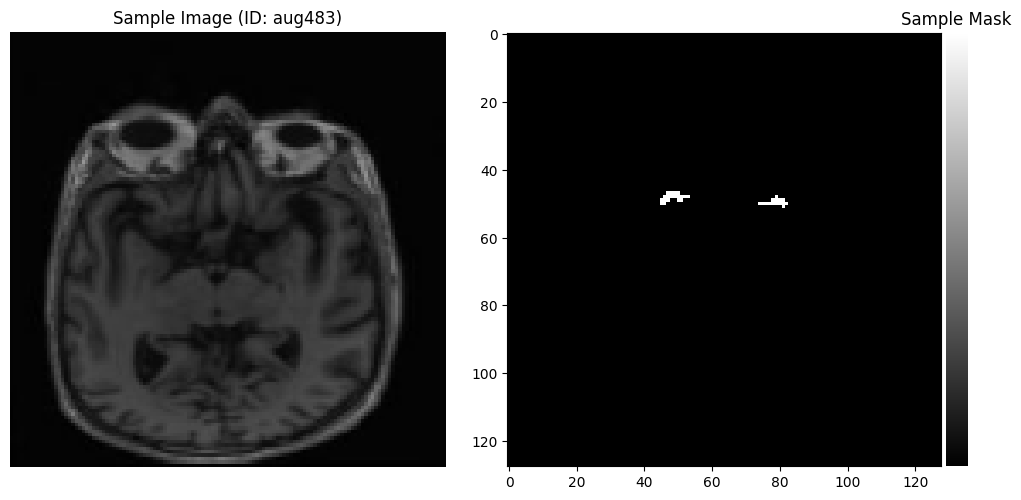

In [7]:
# Purpose: Load images and masks, match files, preprocess data, and prepare X_train, Y_train.
# Constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Define dataset paths
data = os.path.join(local_dataset_path, 'aug/images')
data_left = os.path.join(local_dataset_path, 'aug/masks/left')
data_right = os.path.join(local_dataset_path, 'aug/masks/right')

# Load file paths
train_data = [os.path.join(dirName, f) for dirName, _, fileList in sorted(os.walk(data)) for f in fileList if '.jpg' in f.lower()]
mask_left = [os.path.join(dirName, f) for dirName, _, fileList in sorted(os.walk(data_left)) for f in fileList if '.jpg' in f.lower()]
mask_right = [os.path.join(dirName, f) for dirName, _, fileList in sorted(os.walk(data_right)) for f in fileList if '.jpg' in f.lower()]
print(f"Found {len(train_data)} image files, {len(mask_left)} left mask files, {len(mask_right)} right mask files.")

# Match files
def extract_id(filename, prefix):
    base = os.path.splitext(os.path.basename(filename))[0]
    return base.replace(prefix, '')

image_ids = [extract_id(f, 'img_') for f in train_data]
left_mask_ids = [extract_id(f, 'maskleft_') for f in mask_left]
right_mask_ids = [extract_id(f, 'maskright_') for f in mask_right]
print("Image IDs:", image_ids)
print("Left mask IDs:", left_mask_ids)
print("Right mask IDs:", right_mask_ids)

common_ids = sorted(list(set(image_ids) & set(left_mask_ids) & set(right_mask_ids)))
print(f"Found {len(common_ids)} complete image-mask pairs.")

train_data = [f for f in train_data if extract_id(f, 'img_') in common_ids]
mask_left = [f for f in mask_left if extract_id(f, 'maskleft_') in common_ids]
mask_right = [f for f in mask_right if extract_id(f, 'maskright_') in common_ids]

train_data.sort(key=lambda x: extract_id(x, 'img_'))
mask_left.sort(key=lambda x: extract_id(x, 'maskleft_'))
mask_right.sort(key=lambda x: extract_id(x, 'maskright_'))

# Verify alignment
for img, ml, mr in zip(train_data, mask_left, mask_right):
    img_id = extract_id(img, 'img_')
    ml_id = extract_id(ml, 'maskleft_')
    mr_id = extract_id(mr, 'maskright_')
    if img_id != ml_id or img_id != mr_id:
        print(f"Warning: Mismatch - Image: {img_id}, Left: {ml_id}, Right: {mr_id}")

if not train_data or not mask_left or not mask_right:
    raise ValueError("No images or masks found after matching.")

# Initialize arrays
X_train = np.zeros((len(train_data), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_data), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

# Load and preprocess
for i in tqdm(range(len(train_data)), desc="Loading images"):
    img = imread(train_data[i])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
    img = img / 255.0
    X_train[i] = img

for i in tqdm(range(len(train_data)), desc="Loading masks"):
    maskl = imread(mask_left[i], as_gray=True)
    maskr = imread(mask_right[i], as_gray=True)
    mask = np.maximum(maskl, maskr)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    mask = (mask > 0.5).astype(np.float32)
    Y_train[i] = mask

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")

# Visualize sample
if X_train.shape[0] > 0:
    id = random.randint(0, X_train.shape[0] - 1)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(X_train[id])
    plt.title(f"Sample Image (ID: {extract_id(train_data[id], 'img_')})")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    imshow(Y_train[id][:, :, 0], cmap='gray')
    plt.title("Sample Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Custom Functions


In [8]:
# Purpose: Define montage function and metrics for evaluation.
def custom_montage(images, n_rows=5, n_cols=5, cmap='gray'):
    if images.shape[0] == 0:
        print("No images to display in montage.")
        return None
    n_images = min(images.shape[0], n_rows * n_cols)
    images = images[:n_images]
    if images.ndim == 4:
        images = images[..., 0]
    h, w = images.shape[1], images.shape[2]
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    ax = ax.ravel()
    for i in range(n_images):
        ax[i].imshow(images[i], cmap=cmap)
        ax[i].axis('off')
    for i in range(n_images, len(ax)):
        ax[i].axis('off')
    plt.tight_layout()
    return fig

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def compute_metrics(y_true, y_pred, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(np.float32)
    y_true_f = y_true.flatten()
    y_pred_f = y_pred_bin.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    true_pos = intersection
    false_pos = np.sum(y_pred_f) - intersection
    false_neg = np.sum(y_true_f) - intersection
    precision = true_pos / (true_pos + false_pos + smooth)
    recall = true_pos / (true_pos + false_neg + smooth)
    return dice, iou_score, precision, recall

# ResUNet Model


In [9]:
# Purpose: Define and compile the ResUNet model for segmentation.
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)

    # Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)

    # Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

resunet_model = ResUNet()
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
resunet_model.compile(optimizer=optimizer, loss=dice_coef_loss, metrics=[dice_coef, iou])
resunet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │         64 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ conv2d_1[0][0],   │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ add[0][0]         │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      4,640 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │        544 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 4,723,057 (18.02 MB)

 Trainable params: 4,715,761 (17.99 MB)

 Non-trainable params: 7,296 (28.50 KB)

# Diffusion Model


In [10]:
# Cell 6: Diffusion Model
# Purpose: Implement a simplified diffusion model for hippocampus segmentation, inspired by Stable Diffusion.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class DiffusionModel(keras.Model):
    def __init__(self, timesteps=100, img_size=(128, 128)):
        super(DiffusionModel, self).__init__()
        self.timesteps = timesteps
        self.img_size = img_size

        # U-Net for noise prediction
        self.unet = self.build_unet()

        # Beta schedule
        self.betas = tf.linspace(1e-4, 0.02, timesteps)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = tf.math.cumprod(self.alphas)

    def build_unet(self):
        # Inputs
        mask_input = layers.Input(shape=(*self.img_size, 1))  # Noisy mask: (None, 128, 128, 1)
        image_input = layers.Input(shape=(*self.img_size, 3))  # MRI image: (None, 128, 128, 3)
        time_input = layers.Input(shape=(1,))  # Timestep: (None, 1)

        # Time embedding
        t_emb = layers.Dense(128, activation='relu')(time_input)  # (None, 128)
        t_emb = layers.Dense(256, activation='relu')(t_emb)  # (None, 256)
        t_emb = layers.Reshape((1, 1, 256))(t_emb)  # (None, 1, 1, 256)
        t_emb = layers.UpSampling2D(size=(128, 128))(t_emb)  # (None, 128, 128, 256)

        # Image preprocessing
        img = layers.Conv2D(64, 3, padding='same', activation='relu')(image_input)  # (None, 128, 128, 64)

        # Encoder
        x = layers.Concatenate()([mask_input, img])  # (None, 128, 128, 65)
        x1 = layers.Conv2D(64, 3, padding='same', activation='relu')(x)  # (None, 128, 128, 64)
        x = layers.MaxPooling2D()(x1)  # (None, 64, 64, 64)
        x2 = layers.Conv2D(128, 3, padding='same', activation='relu')(x)  # (None, 64, 64, 128)
        x = layers.MaxPooling2D()(x2)  # (None, 32, 32, 128)
        x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)  # (None, 32, 32, 256)

        # Middle
        x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)  # (None, 32, 32, 256)
        x = layers.Add()([x, layers.Conv2D(256, 1, padding='same')(t_emb[:, :32, :32, :])])  # (None, 32, 32, 256)

        # Decoder
        x = layers.UpSampling2D()(x)  # (None, 64, 64, 256)
        x = layers.Concatenate()([x, x2])  # (None, 64, 64, 384)
        x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)  # (None, 64, 64, 128)
        x = layers.UpSampling2D()(x)  # (None, 128, 128, 128)
        x = layers.Concatenate()([x, x1])  # (None, 128, 128, 192)
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)  # (None, 128, 128, 64)

        # Output: predicted noise
        outputs = layers.Conv2D(1, 3, padding='same', activation='linear')(x)  # (None, 128, 128, 1)
        return keras.models.Model([mask_input, image_input, time_input], outputs)

    def call(self, inputs, training=False):
        mask, image, t = inputs
        return self.unet([mask, image, t], training=training)

    def train_step(self, data):
        x, y = data  # x: images (None, 128, 128, 3), y: masks (None, 128, 128, 1)
        batch_size = tf.shape(x)[0]
        t = tf.random.uniform([batch_size], 0, self.timesteps, dtype=tf.int32)

        # Add noise
        sqrt_alpha_bar = tf.sqrt(tf.gather(self.alpha_bars, t))[:, None, None, None]
        sqrt_one_minus_alpha_bar = tf.sqrt(1.0 - tf.gather(self.alpha_bars, t))[:, None, None, None]
        noise = tf.random.normal(tf.shape(y))
        y_noisy = sqrt_alpha_bar * y + sqrt_one_minus_alpha_bar * noise

        with tf.GradientTape() as tape:
            predicted_noise = self([y_noisy, x, tf.cast(t, tf.float32) / self.timesteps], training=True)
            loss = tf.reduce_mean(tf.square(noise - predicted_noise))

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {'loss': loss}

    def generate(self, images, steps=50):
        x_t = tf.random.normal([images.shape[0], *self.img_size, 1])
        for t in range(steps - 1, -1, -1):
            t_tensor = tf.ones([images.shape[0]], dtype=tf.float32) * t
            predicted_noise = self([x_t, images, t_tensor / self.timesteps], training=False)
            alpha = tf.gather(self.alphas, t)
            alpha_bar = tf.gather(self.alpha_bars, t)
            x_t = (x_t - ((1 - alpha) / tf.sqrt(1 - alpha_bar)) * predicted_noise) / tf.sqrt(alpha)
        return tf.clip_by_value(x_t, 0, 1)

# Instantiate and compile
diffusion_model = DiffusionModel(timesteps=100)
diffusion_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))